In [67]:
#importation des librairies
import yfinance as yf
from datetime import date
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

## Récupération des données

In [53]:
#Récupération des données excel
path = r"/Users/thomascgd/Desktop/Esilv/A5/PI2/Donnees_Bloomberg_Daily.xlsx"
data = pd.read_excel(path)

#Réindexation
data.index=data['Date']
del data['Date']

#Suppression des lignes possédant des NaN.
data=data.dropna()

#récupération du S&P 500
SnP = yf.download('^GSPC',"2000-01-01","2023-12-31")

#SnP
data

[*********************100%%**********************]  1 of 1 completed


,Bloomberg Barclays Global Aggregate Bond,Bloomberg Barclays Emerging Markets USD Aggregate,Bloomberg Commodity Index,Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD,Bloomberg Barclays Pan-European High Yield Hedged to USD,Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD,Bloomberg Barclays US Corporate,Bloomberg Barclays US Corporate High Yield,Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years
Date,,,,,,,,,
2000-01-31,209.9137,231.7258,147.8610,100.21,113.14,275.6170,995.43,546.93,110.098
2000-02-29,209.5158,243.1049,150.4460,101.16,114.67,276.6531,1004.66,547.99,110.522
2000-03-31,213.7084,249.8806,151.9040,102.52,114.38,281.5288,1013.22,536.47,113.565
2000-04-28,208.4867,246.1373,150.0390,102.70,114.84,282.8017,1004.33,537.33,114.718
2000-05-31,209.4520,240.2646,160.1370,102.56,111.47,285.8669,1000.58,531.82,114.478
...,...,...,...,...,...,...,...,...,...
2021-12-27,532.0166,1264.7040,214.3779,295.98,517.22,819.2017,3520.81,2461.96,389.891
2021-12-28,531.8620,1265.4540,213.6978,295.97,517.32,819.3927,3518.94,2463.02,389.891
2021-12-29,531.1477,1264.3740,213.9740,295.25,517.24,817.3085,3504.71,2461.94,389.647


## Risk Factor Lens

In [54]:
Lens=pd.DataFrame(index=data.index,columns=['Rates','Equity','Credit','Commodity','Inflation'])

Lens['Rates']=data['Bloomberg Barclays Global Government 7 to 10 Years Hedged to USD ']
Lens['Credit']=data['Bloomberg Barclays Pan-European Aggregate Corporate Hedged to USD']
Lens['Commodity']=data['Bloomberg Commodity Index']
Lens['Inflation']=data['Bloomberg Barclays US Government Inflation-Linked 7 to 10 Years']

for date in Lens.index:
    if date in SnP.index:
        Lens.loc[date,'Equity']=SnP.loc[date,'Adj Close']
        
# Nettoyage car SnP index n'a pas toute les dates demandées
Lens=Lens.dropna()

# Calcul des rendements
for col in Lens.columns:
    Lens[col]=Lens[col].pct_change()

# ajustement des rendements  
for col in Lens.columns:
    Lens[col]=Lens[col].values.reshape(-1,1)

# nettoyage
Lens=Lens.dropna()

Lens

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.013444,0.009691,0.027533
2000-04-28,0.004521,-0.030796,0.001756,-0.012277,0.010153
2000-05-31,0.010839,-0.021915,-0.001363,0.067303,-0.002092
2000-06-30,0.005828,0.023934,0.004485,0.023599,0.011452
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,0.000068,0.014942,0.004043
2021-12-28,0.000233,-0.001010,-0.000034,-0.003172,0.000000
2021-12-29,-0.002544,0.001402,-0.002433,0.001292,-0.000626


## Exponentially-weighted regression

In [55]:
Lens_adj=Lens.copy(deep=True)
Lens_adj

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.013444,0.009691,0.027533
2000-04-28,0.004521,-0.030796,0.001756,-0.012277,0.010153
2000-05-31,0.010839,-0.021915,-0.001363,0.067303,-0.002092
2000-06-30,0.005828,0.023934,0.004485,0.023599,0.011452
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,0.000068,0.014942,0.004043
2021-12-28,0.000233,-0.001010,-0.000034,-0.003172,0.000000
2021-12-29,-0.002544,0.001402,-0.002433,0.001292,-0.000626


In [56]:
# Define the rolling window size
rolling_window = 252  # Assuming daily returns with approximately 252 trading days in a year

# Exponentially weighted residualization process using pd.ewm() and pd.DataFrame.rolling()
def ewm_residualize(donnees, dependent_column, independent_columns, span):
    result = pd.DataFrame(index=donnees.index)
    
    for col in independent_columns:
        # Calculate EWMA of the independent variable
        ewma_x = donnees[col].ewm(span=span).mean()

        # Calculate EWMA of the dependent variable
        ewma_y = donnees[dependent_column].ewm(span=span).mean()

        # Calculate residuals using rolling regression
        residuals = donnees[dependent_column] - ewma_y
        for i in range(rolling_window, len(donnees)):
            window_data = donnees[i - rolling_window:i + 1]
            window_ewma_x = ewma_x[i - rolling_window:i + 1]

            # Rolling regression to calculate residuals
            X = np.column_stack((np.ones_like(window_ewma_x), window_ewma_x))
            beta = np.linalg.lstsq(X, window_data[dependent_column], rcond=None)[0]
            residuals.iloc[i] = window_data[dependent_column].iloc[-1] - np.dot(X[-1, :], beta)

        result[col + '_residual'] = residuals
    
    return result

In [57]:
span_parameter = 20  # Adjust span parameter based on preferences
#residualized_data = ewm_residualize(Returns, 'Credit', ['Rates', 'Equity'], span_parameter)
for i in range(2,len(Lens_adj.columns)):
    residualized_data = ewm_residualize(Lens_adj, Lens_adj.columns[i], ['Rates', 'Equity'], span_parameter)
    for d in range(len(Lens_adj.index)):
        for j in residualized_data.columns:
            Lens_adj.iloc[d,i]=Lens_adj.iloc[d,i]-residualized_data[j].iloc[d]

Lens_adj

,Rates,Equity,Credit,Commodity,Inflation
Date,,,,,
2000-02-29,0.003759,-0.020108,0.009480,0.017483,0.003851
2000-03-31,0.017624,0.096720,0.009678,0.017093,0.005035
2000-04-28,0.004521,-0.030796,0.014166,0.020210,0.017913
2000-05-31,0.010839,-0.021915,0.011901,-0.022801,0.020848
2000-06-30,0.005828,0.023934,0.005674,0.021555,0.008307
...,...,...,...,...,...
2021-12-27,0.000252,0.013839,-0.000223,-0.009607,-0.003232
2021-12-28,0.000233,-0.001010,-0.000091,0.007706,0.000748
2021-12-29,-0.002544,0.001402,0.001953,0.003382,0.000943


## HMM

In [81]:
# Création des dataset pour s'entrainer et tester
df_train = Lens_adj[Lens_adj.index<pd.to_datetime('2010-01-01')]
df_test = Lens_adj[Lens_adj.index>pd.to_datetime('2010-01-01')]

num_states=3

model = hmm.GaussianHMM(n_components=num_states, covariance_type='full',n_iter = 10000, random_state = 10000)
model.fit(df_train)
market_states = model.predict(df_test)
Proba_market_states=model.predict_proba(df_test)

# Ajoutez les états de marché en tant que colonne dans les données
res=np.column_stack((df_test, market_states,Proba_market_states))
res=pd.DataFrame(res,index=df_test.index,columns=['Rates','Equity','Credit','Commodity','Inflation','Market_State','0','1','2'])
res #rendements journaliers

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2
Date,,,,,,,,,
2010-01-04,0.000234,0.016043,-0.001101,-0.017598,-0.001371,1.0,2.899633e-22,1.000000,4.261051e-110
2010-01-05,0.001241,0.003116,-0.000949,0.005841,-0.003107,2.0,8.134830e-08,0.012690,9.873100e-01
2010-01-06,-0.001660,0.000546,0.000071,-0.015626,0.001326,2.0,4.269214e-09,0.000324,9.996760e-01
2010-01-07,0.000519,0.004001,-0.002028,0.019827,-0.001856,2.0,2.630410e-10,0.000066,9.999342e-01
2010-01-08,0.000353,0.002882,-0.000379,0.007665,-0.001684,2.0,1.311425e-10,0.000013,9.999873e-01
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000252,0.013839,-0.000223,-0.009607,-0.003232,2.0,1.639252e-10,0.000042,9.999580e-01
2021-12-28,0.000233,-0.001010,-0.000091,0.007706,0.000748,2.0,5.123231e-11,0.000010,9.999901e-01
2021-12-29,-0.002544,0.001402,0.001953,0.003382,0.000943,2.0,6.792185e-10,0.000017,9.999826e-01


In [82]:
# Affichez les statistiques des différents états de marché
for state in range(num_states):
    state_data = res[res['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 4
          Rates    Equity    Credit  Commodity  Inflation
count  4.000000  4.000000  4.000000   4.000000   4.000000
mean   0.001962 -0.029944 -0.004887  -0.020935  -0.015529
std    0.008102  0.024901  0.011356   0.027599   0.019802
min   -0.009681 -0.051831 -0.017364  -0.050135  -0.033654
25%    0.000011 -0.045477 -0.009314  -0.037381  -0.030182
50%    0.004322 -0.036327 -0.006189  -0.023988  -0.018926
75%    0.006273 -0.020793 -0.001761  -0.007542  -0.004273
max    0.008885  0.004708  0.010194   0.014373   0.009387

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 54
           Rates     Equity     Credit  Commodity  Inflation
count  54.000000  54.000000  54.000000  54.000000  54.000000
mean    0.000202  -0.003376   0.001227  -0.002140   0.002320
std     0.004076   0.045578   0.003636   0.017169   0.008988
min    -0.009363  -0.119841  -0.005162  -0.0354

In [83]:
res_annuel=res.copy(deep=True)

for col in res_annuel.columns[:5]:
    res_annuel[col]=res_annuel[col]*np.sqrt(252)

res_annuel

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2
Date,,,,,,,,,
2010-01-04,0.003723,0.254681,-0.017480,-0.279354,-0.021763,1.0,2.899633e-22,1.000000,4.261051e-110
2010-01-05,0.019707,0.049460,-0.015062,0.092725,-0.049319,2.0,8.134830e-08,0.012690,9.873100e-01
2010-01-06,-0.026348,0.008660,0.001129,-0.248061,0.021053,2.0,4.269214e-09,0.000324,9.996760e-01
2010-01-07,0.008235,0.063517,-0.032190,0.314744,-0.029459,2.0,2.630410e-10,0.000066,9.999342e-01
2010-01-08,0.005609,0.045746,-0.006016,0.121684,-0.026730,2.0,1.311425e-10,0.000013,9.999873e-01
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.004006,0.219686,-0.003544,-0.152514,-0.051309,2.0,1.639252e-10,0.000042,9.999580e-01
2021-12-28,0.003701,-0.016036,-0.001442,0.122334,0.011881,2.0,5.123231e-11,0.000010,9.999901e-01
2021-12-29,-0.040378,0.022254,0.030999,0.053680,0.014967,2.0,6.792185e-10,0.000017,9.999826e-01


In [84]:
# Affichez les statistiques des différents états de marché
for state in range(num_states):
    state_data = res_annuel[res_annuel['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 4
          Rates    Equity    Credit  Commodity  Inflation
count  4.000000  4.000000  4.000000   4.000000   4.000000
mean   0.031143 -0.475348 -0.077577  -0.332331  -0.246523
std    0.128621  0.395291  0.180275   0.438117   0.314354
min   -0.153675 -0.822788 -0.275645  -0.795872  -0.534237
25%    0.000167 -0.721930 -0.147862  -0.593411  -0.479130
50%    0.068604 -0.576668 -0.098245  -0.380805  -0.300438
75%    0.099580 -0.330086 -0.027960  -0.119725  -0.067831
max    0.141039  0.074734  0.161824   0.228160   0.149021

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 54
           Rates     Equity     Credit  Commodity  Inflation
count  54.000000  54.000000  54.000000  54.000000  54.000000
mean    0.003209  -0.053600   0.019481  -0.033973   0.036834
std     0.064706   0.723531   0.057717   0.272551   0.142680
min    -0.148625  -1.902410  -0.081939  -0.5626

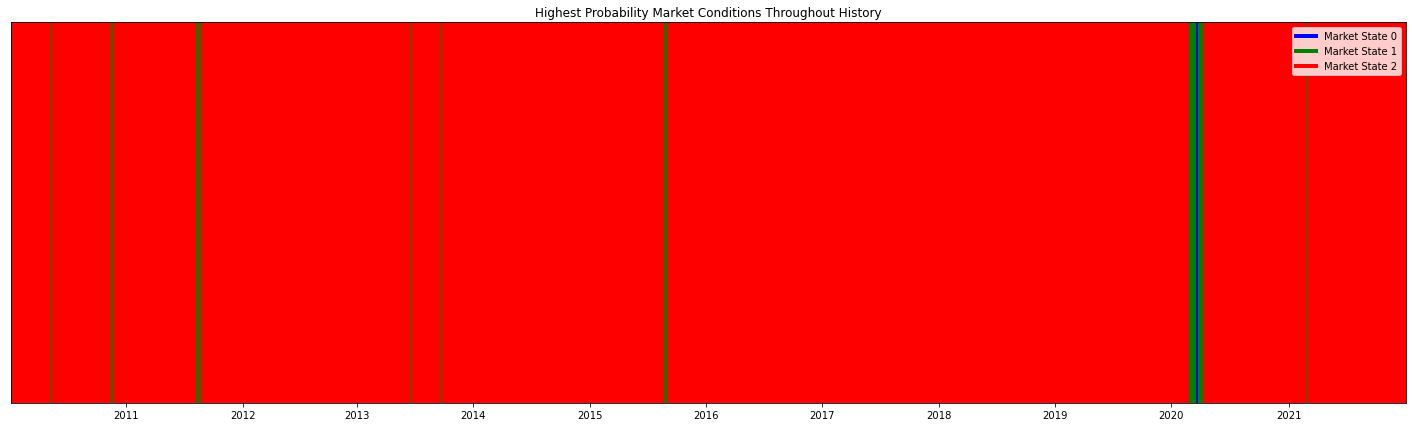

In [85]:
# Couleurs pour chaque régime de marché
colors = {'0': 'blue', '1': 'green', '2': 'red'}

# Création d'une figure pour la frise
fig, ax = plt.subplots(figsize=(25, 7))

# Hauteur du rectangle pour la frise
rectangle_height = 1

# Tracé des rectangles pour chaque date
for i, date in enumerate(res.index):
    # Déterminer la couleur en fonction du régime de marché
    market_state = str(int(res.at[date, 'Market_State']))  # Conversion en chaîne après conversion en entier
    color = colors[market_state]
    
    # Création du rectangle
    rect = patches.Rectangle((i, 0), 1, rectangle_height, color=color)
    ax.add_patch(rect)

# Configuration de l'axe des x pour afficher uniquement les années
years = [date.year for date in res.index]
change_years = [i for i in range(1, len(years)) if years[i] != years[i-1]]
ax.set_xticks(change_years)
ax.set_xticklabels([years[i] for i in change_years])

# Configuration des limites de l'axe
ax.set_xlim(0, len(res))
ax.set_ylim(0, rectangle_height)
ax.set_yticks([])  # Pas de marques sur l'axe des y

# Création d'une légende pour les états de marché
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Market State {state}') for state, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper right')

# Titre et affichage du graphique
ax.set_title('Highest Probability Market Conditions Throughout History')
plt.show()

In [86]:
#Résultats en pourcentage
res_pct=res_annuel.copy(deep=True)

for col in res_pct.columns[:5]:
    res_pct[col]=res_pct[col]*100

res_pct

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2
Date,,,,,,,,,
2010-01-04,0.372251,25.468136,-1.747996,-27.935440,-2.176335,1.0,2.899633e-22,1.000000,4.261051e-110
2010-01-05,1.970726,4.945982,-1.506229,9.272539,-4.931860,2.0,8.134830e-08,0.012690,9.873100e-01
2010-01-06,-2.634816,0.865987,0.112898,-24.806086,2.105265,2.0,4.269214e-09,0.000324,9.996760e-01
2010-01-07,0.823541,6.351711,-3.218980,31.474450,-2.945932,2.0,2.630410e-10,0.000066,9.999342e-01
2010-01-08,0.560883,4.574600,-0.601555,12.168365,-2.673018,2.0,1.311425e-10,0.000013,9.999873e-01
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.400645,21.968629,-0.354405,-15.251365,-5.130866,2.0,1.639252e-10,0.000042,9.999580e-01
2021-12-28,0.370120,-1.603571,-0.144207,12.233426,1.188110,2.0,5.123231e-11,0.000010,9.999901e-01
2021-12-29,-4.037826,2.225440,3.099863,5.367973,1.496677,2.0,6.792185e-10,0.000017,9.999826e-01


In [87]:
# Affichez les statistiques des différents états de marché en bp
for state in range(num_states):
    state_data = res_pct[res_pct['Market_State'] == state]
    print("\n ------------------------------------------- \n")
    print(f"État de marché {state} - Nombre d'observations : {len(state_data)}")
    print(state_data.iloc[:,:5].describe()) 


 ------------------------------------------- 

État de marché 0 - Nombre d'observations : 4
           Rates     Equity     Credit  Commodity  Inflation
count   4.000000   4.000000   4.000000   4.000000   4.000000
mean    3.114304 -47.534759  -7.757739 -33.233072 -24.652315
std    12.862110  39.529085  18.027456  43.811670  31.435396
min   -15.367513 -82.278785 -27.564450 -79.587189 -53.423704
25%     0.016727 -72.193015 -14.786188 -59.341108 -47.913014
50%     6.860436 -57.666833  -9.824476 -38.080550 -30.043849
75%     9.958013 -33.008577  -2.796027 -11.972513  -6.783150
max    14.103858   7.473414  16.182446  22.816001  14.902141

 ------------------------------------------- 

État de marché 1 - Nombre d'observations : 54
           Rates      Equity     Credit  Commodity  Inflation
count  54.000000   54.000000  54.000000  54.000000  54.000000
mean    0.320895   -5.359965   1.948059  -3.397309   3.683406
std     6.470564   72.353105   5.771715  27.255140  14.267988
min   -14.862529

In [88]:
print("\nStart probabilities:")
print(model.startprob_)
print("\nTransition matrix:")
print(model.transmat_)


Start probabilities:
[1.70690875e-018 1.00000000e+000 4.08463745e-112]

Transition matrix:
[[4.26079641e-01 5.73919864e-01 4.95446258e-07]
 [2.17197665e-02 8.67092100e-01 1.11188134e-01]
 [3.50866882e-04 9.00411658e-03 9.90645017e-01]]


In [89]:
res

,Rates,Equity,Credit,Commodity,Inflation,Market_State,0,1,2
Date,,,,,,,,,
2010-01-04,0.000234,0.016043,-0.001101,-0.017598,-0.001371,1.0,2.899633e-22,1.000000,4.261051e-110
2010-01-05,0.001241,0.003116,-0.000949,0.005841,-0.003107,2.0,8.134830e-08,0.012690,9.873100e-01
2010-01-06,-0.001660,0.000546,0.000071,-0.015626,0.001326,2.0,4.269214e-09,0.000324,9.996760e-01
2010-01-07,0.000519,0.004001,-0.002028,0.019827,-0.001856,2.0,2.630410e-10,0.000066,9.999342e-01
2010-01-08,0.000353,0.002882,-0.000379,0.007665,-0.001684,2.0,1.311425e-10,0.000013,9.999873e-01
...,...,...,...,...,...,...,...,...,...
2021-12-27,0.000252,0.013839,-0.000223,-0.009607,-0.003232,2.0,1.639252e-10,0.000042,9.999580e-01
2021-12-28,0.000233,-0.001010,-0.000091,0.007706,0.000748,2.0,5.123231e-11,0.000010,9.999901e-01
2021-12-29,-0.002544,0.001402,0.001953,0.003382,0.000943,2.0,6.792185e-10,0.000017,9.999826e-01


In [94]:
s=res.iloc[:,6:].copy(deep=True)

s['3']=0
s

,0,1,2,3
Date,,,,
2010-01-04,2.899633e-22,1.000000,4.261051e-110,0
2010-01-05,8.134830e-08,0.012690,9.873100e-01,0
2010-01-06,4.269214e-09,0.000324,9.996760e-01,0
2010-01-07,2.630410e-10,0.000066,9.999342e-01,0
2010-01-08,1.311425e-10,0.000013,9.999873e-01,0
...,...,...,...,...
2021-12-27,1.639252e-10,0.000042,9.999580e-01,0
2021-12-28,5.123231e-11,0.000010,9.999901e-01,0
2021-12-29,6.792185e-10,0.000017,9.999826e-01,0


In [95]:
# Chemin du fichier CSV
chemin_fichier_csv = "/Users/thomascgd/Desktop/Esilv/A5/PI2/HMM_Proba.csv"

s.to_csv(chemin_fichier_csv,index=True)